### Генерация поэзии с помощью нейронных сетей: шаг 1
##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

Ваша основная задача: научиться генерироват стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [5]:
# do not change the code in the block below
# __________start of block__________
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
# __________end of block__________

In [6]:
# do not change the code in the block below
# __________start of block__________
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))
# __________end of block__________

cuda device is available


#### 1. Загрузка данных.

In [7]:
# do not change the code in the block below
# __________start of block__________
!wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = "".join([x.replace('\t\t', '').lower() for x in text])
# __________end of block__________

--2024-11-04 09:46:11--  https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt.5’

onegin.txt.5        100%[===================>] 256.37K  --.-KB/s    in 0.004s  

2024-11-04 09:46:11 (60.7 MB/s) - ‘onegin.txt.5’ saved [262521/262521]



#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [8]:
# do not change the code in the block below
# __________start of block__________
tokens = sorted(set(text.lower())) + ['<sos>']
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]
# __________end of block__________

Seems fine!


__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятие №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [9]:
# do not change the code in the block below
# __________start of block__________
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))
# __________end of block__________

Пример батча:

In [10]:
next(generate_chunk()).shape

(256, 101)

In [11]:
# def random_training_set():
#     # Получаем фрагмент данных из генератора
#     chunk = next(generate_chunk())

#     # inp — это все символы, кроме последнего в каждой строке
#     # target — это все символы, начиная со второго, т.е. сдвинутые на один символ вправо
#     inp = torch.tensor(chunk[:, :-1], dtype=torch.int)     # Все строки, кроме последнего столбца
#     target = torch.tensor(chunk[:, 1:], dtype=torch.int)   # Все строки, начиная со второго столбца

#     return inp, target

In [12]:
next(generate_chunk()).shape

(256, 101)

Далее вам предстоит написать код для обучения модели и генерации текста.

In [13]:
class RNN(nn.Module):
    def __init__(self, num_tokens, hidden_size, output_size=None, n_layers=1, device='cpu'):
        super(RNN, self).__init__()
        self.num_tokens = num_tokens
        self.hidden_size = hidden_size
        self.output_size = output_size if output_size else num_tokens
        self.n_layers = n_layers
        self.device = device

        # Embedding слой для преобразования индексов токенов в вектора
        self.encoder = nn.Embedding(num_tokens, hidden_size)

        # GRU слой для обработки последовательностей
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, batch_first=True)

        # Полносвязный слой для предсказания на каждом временном шаге
        self.decoder = nn.Linear(hidden_size, self.output_size)

    def forward(self, input, hidden):
        # Пропускаем входные индексы через Embedding слой
        input = self.encoder(input)  # Форма: (batch_size, seq_length, hidden_size)

        # Передача данных через GRU слой
        output, hidden = self.gru(input, hidden)  # Форма output: (batch_size, seq_length, hidden_size)

        # Преобразование скрытых состояний в предсказания
        output = self.decoder(output)  # Форма: (batch_size, seq_length, output_size)

        return output, hidden

    def init_hidden(self, batch_size):
        # Инициализация скрытого состояния
        return torch.zeros(self.n_layers, batch_size, self.hidden_size, device=self.device)



In [14]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def train(inp, target, model, criterion, optimizer):
    batch_size, seq_length = inp.size()
    hidden = model.init_hidden(batch_size)

    model.zero_grad()  # Обнуляем градиенты
    loss = 0

    # Прямой проход через модель
    output, hidden = model(inp, hidden)  # Полная последовательность передаётся разом

    # Преобразование выходов и целевых меток для расчёта функции потерь
    output = output.view(-1, model.output_size)  # Преобразуем в (batch_size * seq_length, output_size)
    target = target.view(-1)                     # Преобразуем в (batch_size * seq_length)

    # Вычисление функции потерь
    loss = criterion(output, target)

    # Обратное распространение ошибки
    loss.backward()
    optimizer.step()

    return loss.item()

In [15]:
n_epochs = 10000
print_every = 100
plot_every = 10
hidden_size = 128
n_layers = 4
lr = 0.0003

model = RNN(num_tokens=num_tokens, hidden_size=hidden_size, n_layers=n_layers, device=device).to(device)
decoder_optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    chunk = next(generate_chunk())
    i = torch.tensor(chunk[:, :-1], dtype=torch.long).to(device)
    p = torch.tensor(chunk[:, 1:], dtype=torch.long).to(device)
    loss = train(i, p, model, criterion, decoder_optimizer)
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))


    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 3s (100 1%) 3.3143]
 6s (200 2%) 3.2485]
 9s (300 3%) 2.8415]
 12s (400 4%) 2.5865]
 15s (500 5%) 2.4588]
 18s (600 6%) 2.3339]
 21s (700 7%) 2.2327]
 24s (800 8%) 2.1554]
 27s (900 9%) 2.0833]
 30s (1000 10%) 2.0776]
 33s (1100 11%) 2.0204]
 36s (1200 12%) 1.9805]
 39s (1300 13%) 1.8586]
 42s (1400 14%) 1.8609]
 45s (1500 15%) 1.7822]
 48s (1600 16%) 1.7584]
 52s (1700 17%) 1.7712]
 55s (1800 18%) 1.7238]
 58s (1900 19%) 1.7161]
 1s (2000 20%) 1.7955]
 4s (2100 21%) 1.6435]
 7s (2200 22%) 1.6147]
 10s (2300 23%) 1.5725]
 13s (2400 24%) 1.5901]
 16s (2500 25%) 1.4844]
 19s (2600 26%) 1.4674]
 22s (2700 27%) 1.5992]
 25s (2800 28%) 1.5266]
 28s (2900 28%) 1.4494]
 31s (3000 30%) 1.5215]
 34s (3100 31%) 1.3934]
 37s (3200 32%) 1.3758]
 40s (3300 33%) 1.3169]
 43s (3400 34%) 1.3567]
 46s (3500 35%) 1.2597]
 49s (3600 36%) 1.2768]
 52s (3700 37%) 1.2162]
 55s (3800 38%) 1.1884]
 58s (3900 39%) 1.2060]
 1s (4000 40%) 1.1920]
 4s (4100 41%) 1.1760]
 7s (4200 42%) 1.1399]
 10s (4300 43%) 1.1

В качестве иллюстрации ниже доступен график значений функции потерь, построенный в ходе обучения авторской сети (сам код для ее обучения вам и предстоит написать).

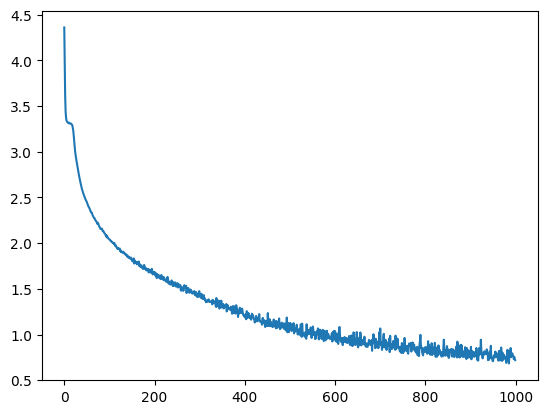

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [17]:
def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling. higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''

    # Преобразуем seed_phrase в тензор индексов токенов
    if seed_phrase is not None:
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
        predicted = seed_phrase
    else:
        x_sequence = [token_to_idx['<sos>']]
        predicted = ""

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    # Инициализация скрытого состояния
    hidden = char_rnn.init_hidden(batch_size=1)

    # Проход по начальной фразе для "настройки" скрытого состояния
    for p in range(len(x_sequence[0]) - 1):
        _, hidden = char_rnn(x_sequence[:, p].unsqueeze(0), hidden)
    inp = x_sequence[:, -1].unsqueeze(0)

    # Генерация текста
    for _ in range(max_length - len(predicted)):
        output, hidden = char_rnn(inp, hidden)

        # Выбор следующего символа из распределения вероятностей
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Добавление сгенерированного символа в строку и обновление входа
        predicted_char = tokens[top_i]
        predicted += predicted_char
        inp = torch.tensor([[top_i]], dtype=torch.int64).to(device)

    return predicted


Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [20]:
print(generate_sample(model, ' мой дядя самых честных правил', max_length=500, temperature=0.5))

 мой дядя самых честных правил.
как мачат ей в чертой задумала,
с коня что ж? махнула горы,
дремочусь, про от колено ленский,
владимир ольгу был рожден
забав нашее верного сохраний,
что на гранится гостей. нетерпелицой,
велиной страшен зарете,
под ней заменился, милый взор
изображает сумраблюдую,
по весь полей простоле
приехал летов и всех напом,
на с ним полей не хотели,
и в самом лестит угрозы,
вы не видит он не предвежда,
и мосье певец ей нет!
как их поведу ламенился;
потом на старый муг досе


### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генериуремого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [ ]:
seed_phrase = ' мой дядя самых честных правил'

In [22]:
generated_phrases = [generate_sample(model, ' мой дядя самых честных правил', max_length=500, temperature=0.5).replace('<sos>', '')\
                     for _ in range(10)
]# your code here

# For example:

# generated_phrases = [
#     generate_sample(
#         model,
#         ' мой дядя самых честных правил',
#         max_length=500,
#         temperature=1.
#     ).replace('<sos>', '')
#     for _ in range(10)
# ]

In [25]:
len(generated_phrases)

10

In [24]:
# do not change the code in the block below
# __________start of block__________

import json
if 'generated_phrases' not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all([x in set(tokens) for x in set(list(phrase))]), 'Unknown tokens detected, check your submission!'


submission_dict = {
    'token_to_idx': token_to_idx,
    'generated_phrases': generated_phrases
}

with open('submission_dict.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict.json`')
# __________end of block__________

File saved to `submission_dict.json`


На этом задание завершено. Поздравляем!